In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2
from scipy.stats import norm

from tqdm import tqdm
import os.path as path
import wget

# Modelo de Ajuste

Definimos un modelo matemático para ajustar los datos, dicha función depende de la variable $x$ y de dos parámetros de ajuste $m$ y $b$.

$$ Y_{fit} = f(x) = mx + b $$

## Función de Costo

Para cuantificar el nivel de acuerdo entre los datos observados y el modelo usamos una función de costo:

$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - Y_{fit}\right)^{2} }{2\sigma_{i}^{2}}$$
$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - (m X_{i}+b)\right)^{2} }{2\sigma_{i}^{2}}$$

In [2]:
!rm Data/*
file = 'Data/data.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/MCMC_Lineal.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/MCMC.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

rm: no se puede borrar 'Data/*': No existe el archivo o el directorio
File loaded


In [3]:
def GetHisto(l,h = 0.2):
    
    xmin_, xmax_ = np.min(l), np.max(l)
    bines = np.arange(xmin_,xmax_+h,h)
    H, bins = np.histogram(l,bins=bines)
    w = np.diff(bins)
    m = bins[:-1] + 0.5*w[0] # Marcas de clase
    HNorm = H / np.sum(H*w)
    
    return H,HNorm,bins,m,w

In [4]:
data = np.loadtxt(Path_, comments='#')
x = data[:,0]
y = data[:,1]
n = len(x)

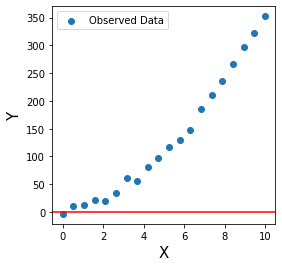

In [5]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.axhline(y=0.,c='r')
ax.set_xlabel('X',fontsize=15)
ax.set_ylabel('Y',fontsize=15)
ax.scatter(x,y,label='Observed Data')
ax.legend(loc=0)